# Seam Phase 1 openVP data creation with Devito

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import segyio
import numpy as np
import random
import matplotlib.pyplot as plt
import pylops
# import devito

from scipy.interpolate import RegularGridInterpolator
# from examples.seismic import Model, RickerSource

# from waveeqmod import Acoustic2DDevito
# from utils import fixed_to_fixed_streamer, fixed_to_continous_streamer

# devito.configuration['log-level'] = 'ERROR'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Velocity model

In [3]:
# Dimensions
nz, nx = 1501, 1751
dz, dx = 10, 20

# Velocity
vp = segyio.open('/mnt/datawaha_dig/Data/Seam_Phase1/SEAM_I_2D_Model/SEAM_Vp_Elastic_N23900.sgy',
                 ignore_geometry=True)
vp2d = segyio.collect(vp.trace[:]).T

#vp2d = vp2d[:-20]
#nz -= 20 # remove bottom layer

In [4]:
# Resample on 12.5 x 12.5 grid
x = np.arange(nx) * dx
z = np.arange(nz) * dz
xint = np.arange(x[0], x[-1], 12.5)
zint = np.arange(z[0], z[-1], 12.5)
nxint, nzint = len(xint), len(zint)
X, Z = np.meshgrid(xint, zint, indexing='ij')
XZ = np.vstack((X.ravel(), Z.ravel())).T

vp2dinterp = np.zeros(nxint*nzint, dtype=np.float32)
interpolator = RegularGridInterpolator((x,z), vp2d.T, bounds_error=False, fill_value=0)
vp2dinterp = interpolator(XZ).reshape(nxint, nzint).T

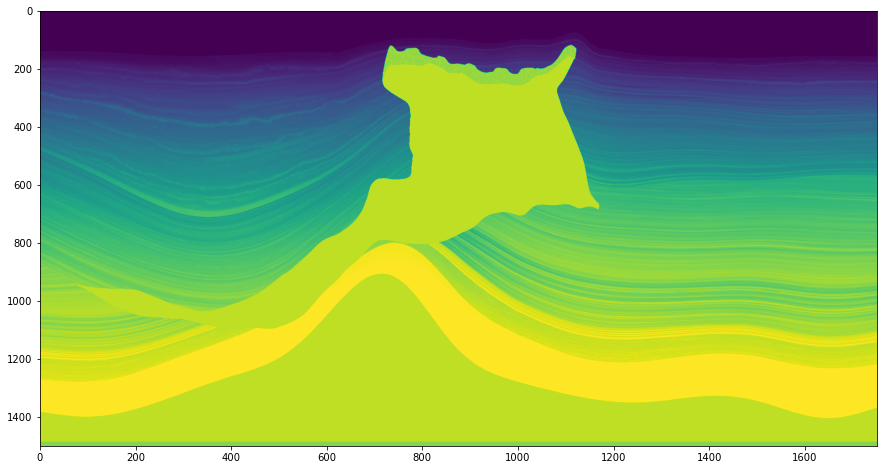

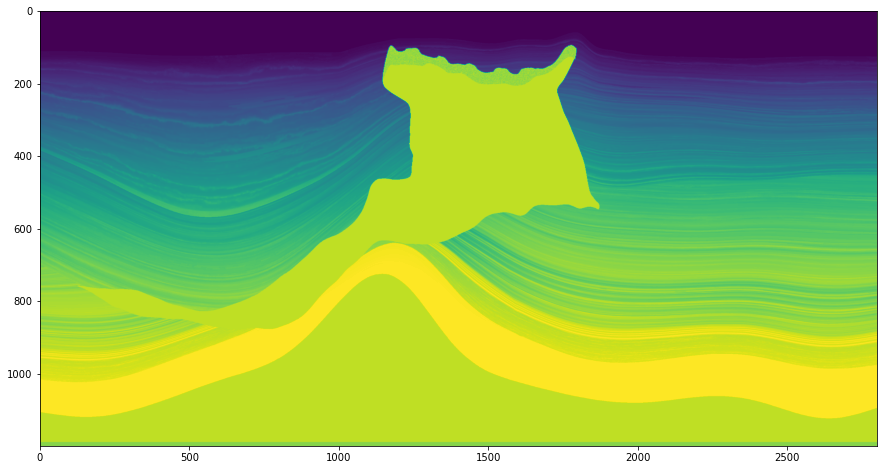

In [5]:
plt.figure(figsize=(15, 8))
plt.imshow(vp2d)
plt.axis('tight')

plt.figure(figsize=(15, 8))
plt.imshow(vp2dinterp)
plt.axis('tight');

## Acquisition geometry

In [ ]:
#model parameter
shape = (nxint, nzint)
spacing = (12.5, 12.5)
origin = (0, 0)

#geometry arrange
nsrc = 501
nrec = nxint
osrc = spacing[0]*800

# other modelling params
nbl = 150 # Number of boundary layers around the domain
space_order = 6 # Space order of the simulation
f0 = 10 # Source peak frequency (1/ms)
fs = True
fslabel = '_fs' if fs else ''

t0 = 0.
tn = 30000 # Total simulation time
tn_blen = 1000000 # Total simulation time of blended data
dt_obs = 4 # Time sampling of observed data

In [ ]:
awe = Acoustic2DDevito()

awe.create_model(shape, origin, spacing, vp2dinterp.T, space_order, nbl=nbl, fs=fs)
awe.create_geometry(src_x=np.arange(0, nsrc) * spacing[0] + osrc,
                    src_z=20,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=20,
                    t0=t0, tn=tn, src_type='Ricker', f0=f0)

In [ ]:
awe.plot_velocity(figsize=(17, 9))

## Solve one shot

In [ ]:
isrc = nsrc//2
d, _, _ = awe.solve_one_shot(isrc)

In [ ]:
ax = awe.plot_shotrecord(d.data, clip=1e-3)

ax = awe.plot_shotrecord(d.data, clip=1e-3, figsize=(17, 5))
ax.set_ylim(2, 0)

# cutting data to wavelet center
wavc = np.argmax(awe.geometry.src.data[:, 0])
plt.figure(figsize=(17, 2))
plt.plot(awe.geometry.time_axis.time_values[:-wavc] * 1e-3, 
         d.data[wavc:, np.argmin(np.abs(awe.geometry.src_positions[isrc, 0] - awe.geometry.rec_positions[:, 0]))])
plt.xlim(0, 2);

plt.figure(figsize=(17, 2))
plt.plot(awe.geometry.time_axis.time_values[:-wavc] * 1e-3, awe.geometry.src.data[wavc:, 0])
plt.xlim(0, 2);

## Solve all shots

In [ ]:
dtot, taxistot = awe.solve_all_shots(dt=dt_obs, figdir=f'figs{fslabel}_open',
                                     datadir=f'shots{fslabel}_open', savedtot=True)

## Create streamer data

First let's assume a fixed receiver array during the firing time of a source

In [ ]:
nrec_streamer = 500 # number of receivers in streamer
ioffrec_streamer = 11 # source-rec offset (in indices)
dstreamer = fixed_to_fixed_streamer(awe.geometry.src_positions[:, 0], 
                                    awe.geometry.rec_positions[:, 0], 
                                    dtot, nrec_streamer=nrec_streamer)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 7))

for iax, isrc in enumerate([0, nsrc//4, 3*nsrc//4, nsrc-1]):
    axs[iax].imshow(dtot[isrc, :].T, extent=(0, nrec*12.5, taxistot[-1] * 1e-3, taxistot[0] * 1e-3), 
                    vmin=-1e-1, vmax=1e-1, cmap='gray')
    axs[iax].axis('tight')
    axs[iax].set_ylim(12, 0);

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 11))

for iax, isrc in enumerate([0, nsrc//4, 3*nsrc//4, nsrc-1]):
    axs[iax].imshow(dstreamer[isrc].T, extent=(0, nrec_streamer*12.5, taxistot[-1] * 1e-3, taxistot[0] * 1e-3), 
                   vmin=-1e-1, vmax=1e-1, cmap='gray')
    axs[iax].axis('tight')
    axs[iax].set_ylim(12, 0);

In [ ]:
np.savez(f'shots{fslabel}_open/Streamer', d=dstreamer.astype(np.float32), t=taxistot, 
         src=awe.geometry.src_positions, rec=awe.geometry.rec_positions)